# Capstone Project: selamat pagi anak-anakku

- Amelia Yunisa
- Mochamad Bayu Safutra
- Rio Ferdinand
- Rizka Salisa Puteri

## Import Library

In [1]:
import os, glob, random, shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import tensorflow as tf
# import tensorflowjs as tfjs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback 

# import evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import textwrap

## Load Dataset Resep

In [2]:
df = pd.read_csv('dataset_resep.csv')

print(df.head())

print(df.info())

# print(df.describe())

print(df.isnull().sum())
print(df.duplicated().sum())

              Nama                                          Deskripsi  \
0      Ayam Goreng  Ayam Goreng adalah hidangan tradisional Indone...   
1        Ayama Pop  Ayam Pop adalah hidangan tradisional Indonesia...   
2            Bakso  Bakso adalah hidangan tradisional Indonesia ya...   
3  Dendeng Batokok  Dendeng merupakan daging kering yang diiris ti...   
4             Gado  Gado-gado adalah hidangan tradisional Indonesi...   

                                               Resep  
0  Bahan-bahan:\n1 kg Ayam, cuci bersih dan poton...  
1  Bahan-bahan :\n1 ekor ayam kampung (bisa pake ...  
2  Bahan-bahan\n250 gr Fillet ayam bagian paha (s...  
3  Bahan-bahan:\n1 kg daging sapi\n1 ons Cabai me...  
4  Bahan-bahan:\n1 buah timun (iris tipis)\n2 tan...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Nama       32 non-null     object
 1   Deskrip

## Splitting Data

In [3]:
src_root  = 'food'
dst_root  = 'food_split'
splits    = {'train': .7, 'validation': .15, 'test': .15}

# 1) Ambil daftar kelas dari src_root/train
classes = os.listdir(os.path.join(src_root, 'train'))

# 2) Buat direktori tujuan per split & per kelas
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(dst_root, split, cls), exist_ok=True)

# 3) Gabungkan file per kelas dari train/validation/test
for cls in classes:
    all_files = []
    for sub in ['train','validation','test']:
        pattern = os.path.join(src_root, sub, cls, '*')
        all_files += glob.glob(pattern)

    random.seed(42)
    random.shuffle(all_files)
    n = len(all_files)
    n_train = int(splits['train'] * n)
    n_val   = int(splits['validation']   * n)

    train_files = all_files[:n_train]
    val_files   = all_files[n_train:n_train+n_val]
    test_files  = all_files[n_train+n_val:]

    # 4) Copy ke folder baru
    for f in train_files:
        shutil.copy(f, os.path.join(dst_root, 'train', cls))
    for f in val_files:
        shutil.copy(f, os.path.join(dst_root, 'validation', cls))
    for f in test_files:
        shutil.copy(f, os.path.join(dst_root, 'test', cls))

    print(f"{cls}: train={len(train_files)}, validation={len(val_files)}, test={len(test_files)}")


ayam_goreng: train=102, validation=22, test=23
ayam_pop: train=147, validation=31, test=33
bakso: train=1507, validation=323, test=324
dendeng_batokok: train=145, validation=31, test=32
gado: train=1501, validation=321, test=323
grontol: train=210, validation=45, test=45
gudeg: train=328, validation=70, test=71
gulai_ikan: train=153, validation=32, test=34
gulai_tambusu: train=126, validation=27, test=28
gulai_tunjang: train=154, validation=33, test=34
kue_ape: train=169, validation=36, test=37
kue_bika_ambon: train=142, validation=30, test=32
kue_cenil: train=142, validation=30, test=31
kue_dadar_gulung: train=162, validation=34, test=36
kue_gethuk_lindri: train=154, validation=33, test=33
kue_kastengel: train=154, validation=33, test=33
kue_klepon: train=168, validation=36, test=36
kue_lapis: train=168, validation=36, test=37
kue_lemper: train=202, validation=43, test=44
kue_lumpur: train=173, validation=37, test=38
kue_nagasari: train=161, validation=34, test=35
kue_pastel: train=16

## Load Dataset

In [4]:
# 1. Atur path dan parameter global
base_dir   = os.getcwd()
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

In [5]:
dst_root  = 'food_split'

## Augmentasi Data

In [6]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,         # Lebih kecil
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

#    b) Hanya rescale untuk validation dan test
val_test_gen = ImageDataGenerator(rescale=1./255)

# 3. Buat generator
train_generator = train_gen.flow_from_directory(
    os.path.join(dst_root, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    shuffle=True
)

validation_generator = val_test_gen.flow_from_directory(
    os.path.join(dst_root, 'validation'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_gen.flow_from_directory(
    os.path.join(dst_root, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 9175 images belonging to 32 classes.
Found 1982 images belonging to 32 classes.
Found 1999 images belonging to 32 classes.


## Modeling

In [7]:
# 1. Load Pretrained MobileNetV2
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# 2. Bangun model transfer learning kamu
model = Sequential([
    base_model,

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')  # jumlah kelas dari generator
])

# 3. Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 4. Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.2, monitor='val_loss')

# 5. Fit model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stop, reduce_lr]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,900,896 (14.88 MB)

 Trainable params: 1,642,912 (6.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

c:\Users\Ferdinand\Downloads\Capstone\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 250s 849ms/step - accuracy: 0.4261 - loss: 2.2144 - val_accuracy: 0.7008 - val_loss: 1.0571 - learning_rate: 0.0010
Epoch 2/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 142s 494ms/step - accuracy: 0.7109 - loss: 1.0314 - val_accuracy: 0.7911 - val_loss: 0.7324 - learning_rate: 0.0010
Epoch 3/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 140s 486ms/step - accuracy: 0.7886 - loss: 0.7616 - val_accuracy: 0.8158 - val_loss: 0.6683 - learning_rate: 0.0010
Epoch 4/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 133s 464ms/step - accuracy: 0.8246 - loss: 0.6200 - val_accuracy: 0.8300 - val_loss: 0.6561 - learning_rate: 0.0010
Epoch 5/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 140s 489ms/step - accuracy: 0.8508 - loss: 0.5089 - val_accuracy: 0.8396 - val_loss: 0.6086 - learning_rate: 0.0010
Epoch 6/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 144s 501ms/step - accuracy: 0.8736 - loss: 0.4787 - val_accuracy: 0.8537 - val_loss: 0.5672 - learning_rate: 0.0010
Epoch 7/20
287/287 ━━━━━━━━━━━━━━━━━━━━ 147s 512ms/step - accura

In [8]:
saved_model_dir = os.path.join(base_dir, 'saved_model_tl')
model.export(saved_model_dir)
print(f"SavedModel folder created at: {saved_model_dir}")

INFO:tensorflow:Assets written to: c:\Users\Ferdinand\Downloads\Capstone\saved_model_tl\assets


INFO:tensorflow:Assets written to: c:\Users\Ferdinand\Downloads\Capstone\saved_model_tl\assets


Saved artifact at 'c:\Users\Ferdinand\Downloads\Capstone\saved_model_tl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 32), dtype=tf.float32, name=None)
Captures:
  1690171421824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1690190940112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1690190939408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1690190938176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1690190939232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1690190946800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1690190945216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1690190948384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1690190943984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1690190946624: TensorSpec(shape=(), dtype=tf.resource, name=N

## Evaluation

c:\Users\Ferdinand\Downloads\Capstone\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 647ms/step
=== Classification Report ===
                   precision    recall  f1-score   support

      ayam_goreng     0.7222    0.6190    0.6667        21
         ayam_pop     0.6857    0.8889    0.7742        27
            bakso     0.9159    0.9414    0.9285       324
  dendeng_batokok     0.8846    0.8214    0.8519        28
             gado     0.9535    0.8885    0.9199       323
          grontol     0.9545    0.9333    0.9438        45
            gudeg     0.7619    0.9014    0.8258        71
       gulai_ikan     0.7143    0.7692    0.7407        26
    gulai_tambusu     0.4615    0.7500    0.5714        24
    gulai_tunjang     0.6250    0.6250    0.6250        32
          kue_ape     0.9333    0.9032    0.9180        31
   kue_bika_ambon     0.9655    0.9032    0.9333        31
        kue_cenil     0.8929    0.8065    0.8475        31
 kue_dadar_gulung     0.7250    0.8286    0.7733        35
kue_gethuk_lindri     0.8485    0.9333    

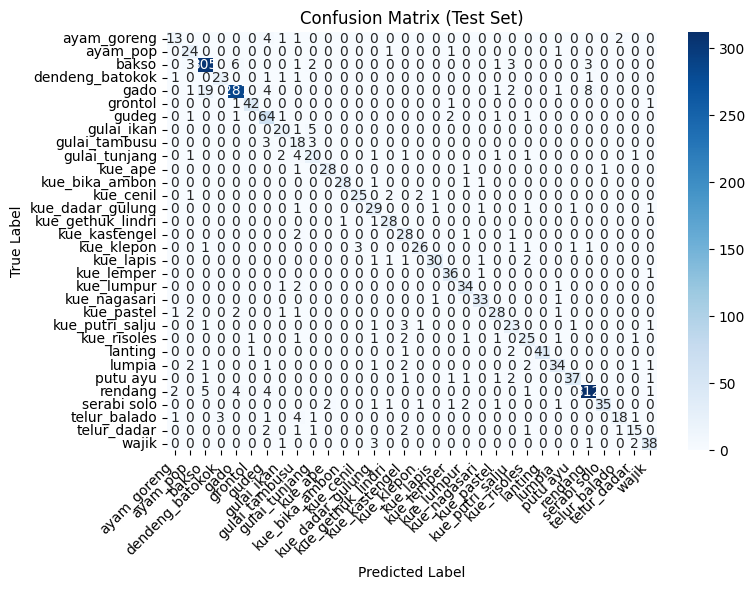

Overall Test Accuracy: 0.8739


In [9]:
# 2. Lakukan prediksi probabilitas untuk semua sampel di test_generator
#    – model.predict akan menghasilkan array shape (n_samples, n_classes)
y_prob = model.predict(
    test_generator,
    verbose=1
)

# 3. Konversi probabilitas jadi label integer (argmax)
y_pred = np.argmax(y_prob, axis=1)

# 4. Ambil label asli (integer) dari test_generator
y_true = test_generator.classes

# 5. Ambil daftar nama kelas (dari folder di direktori test)
#    class_indices: dict { 'nama_folder': index, ... }
#    kita perlu urutan yang sama dengan index (0,1,2,...)
class_indices = test_generator.class_indices
# Buat list di mana index ke-i berisi nama kelas dengan index i
# (kelas-kelas akan diurutkan berdasarkan nilai index di class_indices)
sorted_labels = sorted(class_indices.items(), key=lambda x: x[1])
class_names = [item[0] for item in sorted_labels]

# -----------------------------------------
# 6. CETAK Classification Report (Per Kelas)
# -----------------------------------------
print("=== Classification Report ===")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

# -----------------------------------------
# 7. PLOT Confusion Matrix (dengan Label)
# -----------------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# -----------------------------------------
# 8. HITUNG dan CETAK AKURASI KESELURUHAN
# -----------------------------------------
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Overall Test Accuracy: {accuracy:.4f}")

In [10]:
class_indices = train_generator.class_indices
# class_indices adalah dict: {'beef': 0, 'chicken': 1, ...}

# Buat list class_names sesuai index urut
class_names = [None] * len(class_indices)
for label, idx in class_indices.items():
    class_names[idx] = label

print("Daftar kelas:", class_names)

Daftar kelas: ['ayam_goreng', 'ayam_pop', 'bakso', 'dendeng_batokok', 'gado', 'grontol', 'gudeg', 'gulai_ikan', 'gulai_tambusu', 'gulai_tunjang', 'kue_ape', 'kue_bika_ambon', 'kue_cenil', 'kue_dadar_gulung', 'kue_gethuk_lindri', 'kue_kastengel', 'kue_klepon', 'kue_lapis', 'kue_lemper', 'kue_lumpur', 'kue_nagasari', 'kue_pastel', 'kue_putri_salju', 'kue_risoles', 'lanting', 'lumpia', 'putu ayu', 'rendang', 'serabi solo', 'telur_balado', 'telur_dadar', 'wajik']


## Inference

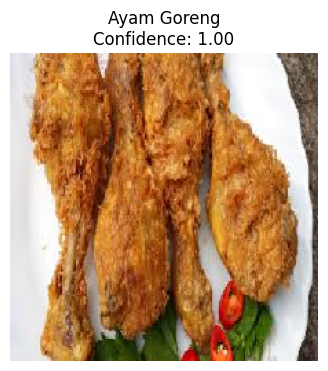

Nama Makanan: Ayam Goreng
Deskripsi:
Ayam Goreng adalah hidangan tradisional Indonesia yang sangat populer
dan menjadi salah satu kuliner yang dicintai di seluruh nusantara.
Hidangan ini terdiri dari potongan ayam yang digoreng hingga kulitnya
menjadi renyah dan berwarna kecoklatan. Sebelum digoreng, ayam
biasanya direndam atau diremas dalam bumbu yang dapat mencakup bawang
putih, ketumbar, garam, dan merica untuk memberikan cita rasa yang
khas. Metode ini memberikan ayam goreng karakteristiknya yang gurih
dan berbumbu. Ayam goreng sering dihidangkan bersama nasi putih dan
sambal sebagai pelengkap. Hidangan ini bisa ditemui di warung-warung
kaki lima, restoran, hingga rumah makan di seluruh Indonesia. Karena
kelezatannya, ayam goreng juga sering dijadikan hidangan dalam acara-
acara khusus, pesta, atau acara keluarga.

Resep:
Bahan-bahan:
1 kg Ayam, cuci bersih dan potong sesuai selera
2 Bonggol bawang putih
1 butir telur ayam
3 sdm tepung maizena
1/2 sdt garam
1/4 sdt kaldu bubuk
Secu

In [11]:
from tensorflow.keras.preprocessing import image

# Digunakan untuk membuka dialog file
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# ----------------------------------
# 1. Setup model inference
# ----------------------------------
BASE_DIR = "."
SAVED_MODEL_DIR = os.path.join(BASE_DIR, "saved_model_tl")
loaded = tf.saved_model.load(SAVED_MODEL_DIR)
infer = loaded.signatures["serving_default"]
_, input_kwargs = infer.structured_input_signature
input_name = list(input_kwargs.keys())[0]
output_key = list(infer.structured_outputs.keys())[0]
IMG_SIZE   = (224, 224)

# ----------------------------------
# 2. Load dataset resep
# ----------------------------------
dataset_resep = pd.read_csv("dataset_resep.csv")
class_names   = dataset_resep['Nama'].values

# ----------------------------------
# 3. Fungsi prediksi + display
# ----------------------------------
def predict_and_display(img_path):
    # Preprocess
    img = image.load_img(img_path, target_size=IMG_SIZE)
    arr = image.img_to_array(img) / 255.0
    batch = np.expand_dims(arr, axis=0).astype(np.float32)
    # Inferensi
    outputs = infer(**{input_name: tf.constant(batch)})
    preds   = outputs[output_key].numpy()[0]
    idx     = np.argmax(preds)
    conf    = float(preds[idx])
    raw_lbl = class_names[idx]
    disp_lbl = raw_lbl.replace("_", " ")
    # Ambil data resep
    row = dataset_resep[dataset_resep['Nama'] == raw_lbl].iloc[0]
    name, desc, resep = row['Nama'], row['Deskripsi'], row['Resep']
    # Tampilkan gambar + judul
    plt.figure(figsize=(4,4))
    plt.imshow(arr)
    plt.axis("off")
    plt.title(f"{disp_lbl}\nConfidence: {conf:.2f}", fontsize=12)
    plt.show()
    # Tampilkan teks resep
    print(f"Nama Makanan: {name}")
    print("Deskripsi:")
    print(textwrap.fill(desc, width=70))
    print("\nResep:")
    print(resep)
    return raw_lbl, conf

# ----------------------------------
# 4. Pilih file via dialog OS
# ----------------------------------
# Supaya jendela root tidak muncul
root = Tk()
root.withdraw()

file_path = askopenfilename(
    title="Pilih gambar untuk inferensi",
    filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")]
)

if file_path:
    predict_and_display(file_path)
else:
    print("Tidak ada file yang dipilih.")
